<div style="float:left">
    <h1 style="width:450px">Live Coding 6: Geopandas</h1>
    <h2 style="width:450px">Working with Spatial Data!</h2>
</div>
<div style="float:right"><img width="100" src="https://github.com/jreades/i2p/raw/master/img/casa_logo.jpg" /></div>

<div style="border: dotted 1px rgb(156,121,26); padding: 10px; margin: 5px; background-color: rgb(255,236,184)"><i>Note</i>: You should download this notebook from GitHub and then save it to your own copy of the repository. I'd suggest adding it (<tt>git add Live-...</tt>) right away and then committing (<tt>git commit -m "Some message"</tt>). Do this again at the end of the class and you'll have a record of everything you did, then you can <tt>git push</tt> it to GitHub.</div>

## Preamble

1. Assessment #1
   - All assessments have rubrics (now).
   - In the interests of seeing everyone get at least a few points, here's a clue for the kind of answers that I'm looking for: do *not* under any circumstances tell me that the answer to Question 1 is that either: a) I provided the data; or b) Airbnb provided the data. That's your clue.
   - I also had an excellent question asking me to clarify what Question 6 means: specifically, what does "kind" mean? I am not asking you to propose a specific analysis, I am asking you to think about directions in which you could take an analysis. Another way is to think about classes of analysis: something a bit more detailed than qualitative vs. quantitative, but more generalised than "I would look at the price distribution in order to find affordable accommodation". The former is kind of obvious, but so is the latter. I'm looking for you to think about "With this data the sorts of things that I could look at include..."
2. Updating Docker
   - Check the config.sh script (if you try to output quarto from Docker and get lmodern.sty error)
   - Previewing Markdown outside of QMD rendering
3. Reading presentations
   - Let's do 4...

## Getting Started with Geo

In [2]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.pyplot as plt

from requests import get
from urllib.parse import urlparse

### Loading and Plotting

In [ ]:
gpkg_src = 'https://bit.ly/2K4JcsB'
world = gpd.read_file(gpkg_src, driver='GPKG')
world.plot(facecolor='white', edgecolor='darkblue')

In [ ]:
#world.to_file('world.gpkg', driver='GPKG')
#world.to_file('world.shp', driver='ESRI Shapefile')
world.to_file('world.geojson', driver='GeoJSON')

In [ ]:
print(isinstance(world.geometry, str))
print(isinstance(world.geometry, pd.Series))
print(isinstance(world.geometry, gpd.GeoSeries))
print(world.crs)

### Reprojection

In [ ]:
world2 = world.to_crs('ESRI:54030')
world2.plot(figsize=(12,8))

### Modifying a Plot

In [ ]:
f,ax = plt.subplots(1,1,figsize=(12,8))
world.to_crs('epsg:27700').plot(ax=ax)
ax.set_xlim([-7500000,7500000])
ax.set_ylim([-7500000,4000000])

### Creating (Geo)Objects from Scratch

In [ ]:
from shapely import wkt
bbox = 'POLYGON((5000000.0 2500000.0, 5000000.0 -2500000.0, -5000000.0 -2500000.0, -5000000.0 2500000.0, 5000000.0 2500000.0))'
bgdf = gpd.GeoDataFrame({'id':[0], 'coordinates':bbox})
bgdf['geometry'] = bgdf.coordinates.apply(wkt.loads)
bgdf = bgdf.set_crs('ESRI:54030')
bgdf.plot(edgecolor='red', facecolor='none')

In [ ]:
scale = int(float('1e7'))
f,ax=plt.subplots(figsize=(8,4))
world2.plot(ax=ax)
bgdf.plot(ax=ax, color='none', edgecolor='r', linewidth=2)
ax.set_xlim([-0.75*scale, +0.75*scale])
ax.set_ylim([-3*scale/10, +3*scale/10])

### Geo-Operations

In [ ]:
gpd.sjoin(world2, bgdf, how='inner', predicate='within').plot()

In [ ]:
gpd.sjoin(world2, bgdf, how='inner', predicate='intersects').plot()

### Other Ops

In [ ]:
gpd.sjoin(world2, bgdf, how='inner', predicate='intersects').envelope.plot()

In [ ]:
gpd.sjoin(world2, bgdf, how='inner', predicate='intersects').convex_hull.plot()

In [ ]:
gpd.sjoin(world2, bgdf, how='inner', predicate='intersects').centroid.plot()

In [ ]:
gpd.sjoin(world2, bgdf, how='inner', predicate='intersects').simplify(5000).explore()

## What's with those `f`, `ax` Things?

Matplotlib treats axes and figures separately. You can think of the axes as the 'thing' (i.e. object) into which you 'pour' your data: the axes respond automatically to the data in terms of range and scale, and can even do things like on-the-fly log transformations if you need them. You can also do things (which we'll see over the next few weeks) like set tick-labels and so forth.

#### Setting the Figure Size

The most common use `f,ax=plt.subplots(...)` is to set a figure size as part of creating a figure environment

. We then pass the axis object returned by the process of _creating_ the subplot to `world2.plot(...)` using `ax=ax` (`<axis for plot>=<axis object from figure>`) so that `world2` is plotted into this axis. Otherwise, it would plot to its _own_ figure environment.

In [ ]:
f,ax=plt.subplots(figsize=(20,10))
print(f"f is {f}")
print(f"ax is {ax}")
world2.plot(ax=ax, facecolor=(0.5, 0.5, 0.5, 0.5), edgecolor='white', linewidth=0.5)
print(f"ax is {ax}") # Notice that axis scales have now changed!

#### Manipulating the Axis

Once we've 'poured' the data from `world2` into the axis, we can then manipulate the axis directly, such as by change the limits of the plot. This _same_ process works for regular charts, so if you had an exponential distribution that ran from 0..2,000,000, you could also just cut off the x-axis at, say, 5,000 in order to keep the scale meaningful.

In [1]:
f,ax=plt.subplots(figsize=(20,10))
world2.plot(ax=ax, facecolor=(1.0, 0.5, 0.5, 0.5), edgecolor='white', linewidth=0.5)
ax.set_xlim([-1.5*1e7, 0.0]) # Change the x-limits using this list: [-15000000, 0]

NameError: name 'plt' is not defined

#### Creating Multi-Part Plots

Subplots can actually create mutli-part plots (i.e. Figures A and B, or A..D, or whatever). This is done using `plt.subplots(<rows>, <columns>, figsize=(<width>,<height>))`. Where figure size is for the _entire_ figure. There are ways to specify the ratio of Figure A to Figure B, but here we're just creating two of them.

In [ ]:
f,axes=plt.subplots(1,2,figsize=(20,10)) # A 1x2 matrix
print(axes)
print(len(axes))

# Pouring into axes[0] axis
world2.plot(ax=axes[0], facecolor=(0.5, 0.5, 0.5, 0.5), edgecolor='white', linewidth=0.5)
axes[0].set_xlim([-1.5*1e7, -0.6*1e7])
axes[0].set_ylim([-2*1e6, 4*1e6])

# Pouring into axes[1] axis
world2.geometry.plot(ax=axes[1], facecolor='none', edgecolor=(0.5, 0.5, 0.5, 0.5), linewidth=0.5)
world2.geometry.centroid.plot(ax=axes[1], markersize=25, color='red')
axes[1].set_xlim([-1.1*1e7, -0.1*1e7])
axes[1].set_ylim([-2*1e6, 4*1e6]) # You can supprss the output (-2000000.0, 4000000.0) by adding a ';' on the end of this line

## Dealing with Much Larger Volumes of Data

Lots of interesting data to be found on the [Chicago Data Portal](https://data.cityofchicago.org/)

In [ ]:
wd = %pwd
print(wd)

<AxesSubplot:>

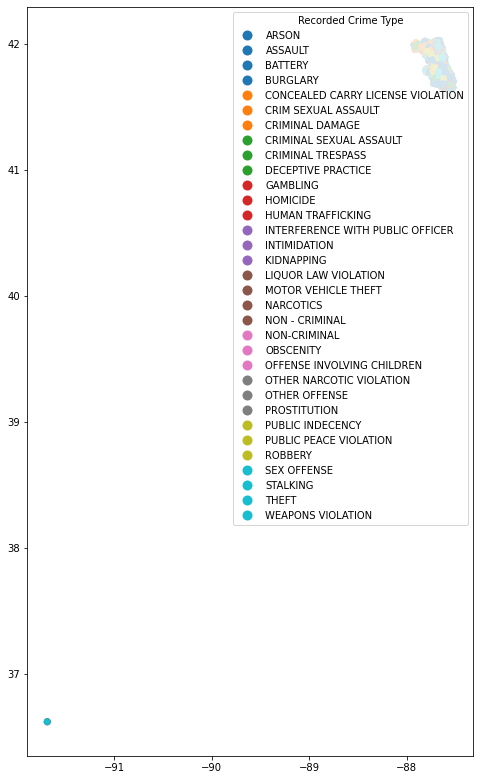

In [12]:
# If it times out, try downloading manually
host = 'https://orca.casa.ucl.ac.uk'
path = '~jreades/data'
fn   = '2022-sample-Crime.csv.gz'
url = f'{host}/{path}/{fn}'
df  = pd.read_csv(url)

gdf = gpd.GeoDataFrame(df, 
            geometry=gpd.points_from_xy(
                        df['Longitude'], 
                        df['Latitude'], 
                        crs='epsg:4326'
            )
      )

f,ax=plt.subplots(figsize=(8,16))
gdf.plot(ax=ax, column='Primary Type', legend=True, legend_kwds={'loc':'upper right', 'title':'Recorded Crime Type'})

In [13]:
print(f"There are {gdf.shape[0]:,} rows in the data set and {gdf.shape[1]} columns.")
print(f"There are {gdf.Latitude.isna().sum():,} rows with null latitudes.")
print(f"There are {gdf.Longitude.isna().sum():,} rows with null longitudes.")

There are 76,444 rows in the data set and 23 columns.
There are 1,332 rows with null latitudes.
There are 1,332 rows with null longitudes.


In [14]:
gdf = gdf.dropna(how='all', subset=['Latitude','Longitude'])
print(f"We now have {gdf.shape[0]:,} rows")

We now have 75,112 rows


In [15]:
gdf = gdf[~((gdf.Longitude < -89) | (gdf.Latitude < 41))]
print(f"We now have {gdf.shape[0]:,} rows")

We now have 75,109 rows


In [16]:
primaries = gdf['Primary Type'].unique()
print(sorted(primaries))

['ARSON', 'ASSAULT', 'BATTERY', 'BURGLARY', 'CONCEALED CARRY LICENSE VIOLATION', 'CRIM SEXUAL ASSAULT', 'CRIMINAL DAMAGE', 'CRIMINAL SEXUAL ASSAULT', 'CRIMINAL TRESPASS', 'DECEPTIVE PRACTICE', 'GAMBLING', 'HOMICIDE', 'HUMAN TRAFFICKING', 'INTERFERENCE WITH PUBLIC OFFICER', 'INTIMIDATION', 'KIDNAPPING', 'LIQUOR LAW VIOLATION', 'MOTOR VEHICLE THEFT', 'NARCOTICS', 'NON - CRIMINAL', 'NON-CRIMINAL', 'OBSCENITY', 'OFFENSE INVOLVING CHILDREN', 'OTHER NARCOTIC VIOLATION', 'OTHER OFFENSE', 'PROSTITUTION', 'PUBLIC INDECENCY', 'PUBLIC PEACE VIOLATION', 'ROBBERY', 'SEX OFFENSE', 'STALKING', 'THEFT', 'WEAPONS VIOLATION']


In [17]:
mapping = {
    'ARSON' : 'Property', 
    'ASSAULT': 'People', 
    'BATTERY': 'People', 
    'BURGLARY': 'Property', 
    'CONCEALED CARRY LICENSE VIOLATION': 'Weapons', 
    'CRIM SEXUAL ASSAULT': 'People', 
    'CRIMINAL DAMAGE': 'Property', 
    'CRIMINAL SEXUAL ASSAULT': 'People', 
    'CRIMINAL TRESPASS': 'Property', 
    'DECEPTIVE PRACTICE': 'People', 
    'GAMBLING': 'People', 
    'HOMICIDE': 'People', 
    'HUMAN TRAFFICKING': 'People', 
    'INTERFERENCE WITH PUBLIC OFFICER': 'People', 
    'INTIMIDATION': 'People', 
    'KIDNAPPING': 'People', 
    'LIQUOR LAW VIOLATION': 'Drugs', 
    'MOTOR VEHICLE THEFT': 'Property', 
    'NARCOTICS': 'Drugs', 
    'NON - CRIMINAL': 'Not a Crime', 
    'NON-CRIMINAL': 'Not a Crime', 
    'OBSCENITY': 'People', 
    'OFFENSE INVOLVING CHILDREN': 'People', 
    'OTHER NARCOTIC VIOLATION': 'Drugs', 
    'OTHER OFFENSE': 'Other', 
    'PROSTITUTION': 'People', 
    'PUBLIC INDECENCY': 'People', 
    'PUBLIC PEACE VIOLATION': 'People', 
    'ROBBERY': 'Property', 
    'SEX OFFENSE': 'People', 
    'STALKING': 'People', 
    'THEFT': 'Property', 
    'WEAPONS VIOLATION': 'Weapons'
}

In [18]:
gdf['Class'] = gdf['Primary Type'].replace(mapping)

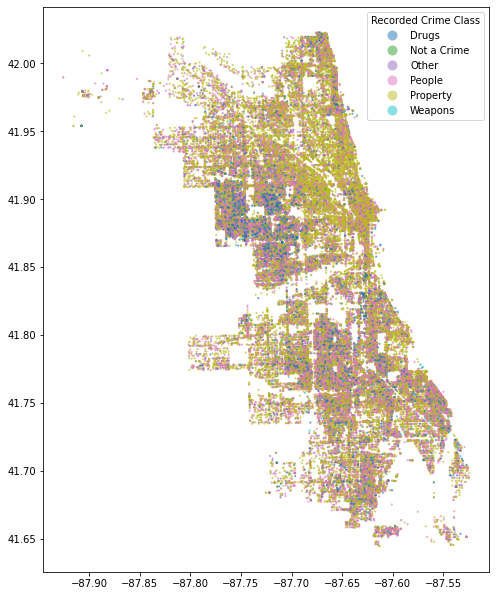

In [19]:
f,ax=plt.subplots(figsize=(8,16))
gdf.plot(ax=ax, column='Class', s=1.5, alpha=0.5, legend=True, legend_kwds={'loc':'upper right', 'title':'Recorded Crime Class'});

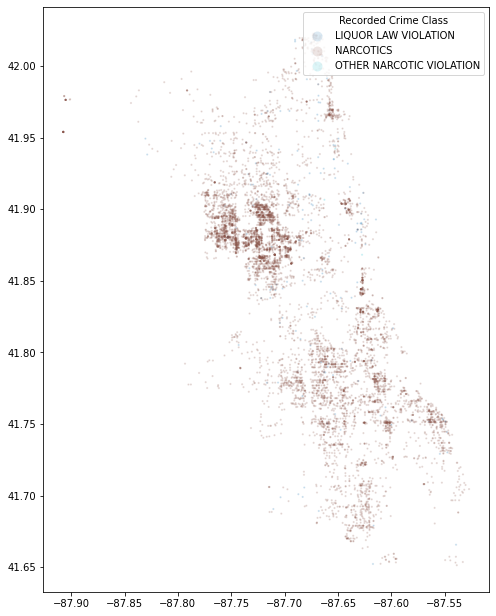

In [20]:
f,ax=plt.subplots(figsize=(8,16))
gdf[gdf.Class=='Drugs'].plot(ax=ax, column='Primary Type', s=1.5, alpha=0.15, legend=True, legend_kwds={'loc':'upper right', 'title':'Recorded Crime Class'});

In [21]:
gdf.to_feather(os.path.join('data','geo','2022-Crime.geofeather'))

#### Census Tracts

In [37]:
os.makedirs(os.path.join('data','geo'), exist_ok=True)
tracts = gpd.read_file( 'https://data.cityofchicago.org/api/geospatial/5jrd-6zik?method=export&format=Original' )
tracts.to_feather(os.path.join('data','geo','Census Tracts.geofeather'))
del(tracts)
#print("Done.")

NAD83 / Illinois East (ftUS) has EPSG code 3435


<AxesSubplot:>

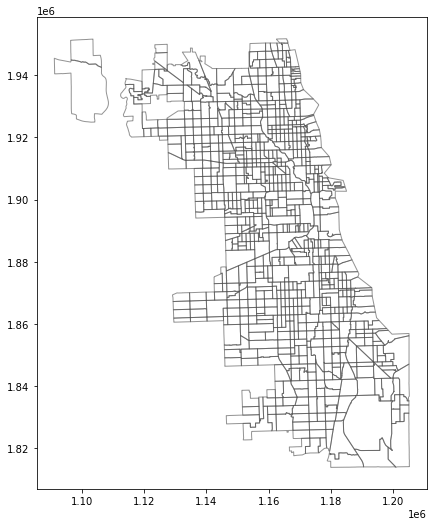

In [54]:
tracts = gpd.read_feather(os.path.join('data','geo','Census Tracts.geofeather'))
print(f"{tracts.crs.name} has EPSG code {tracts.crs.to_epsg()}")
tracts.plot(figsize=(7,10), edgecolor=(0.3, 0.3, 0.3, 0.6), facecolor='none')

#### Building Data

Here we can read building outlines for the entire city (it's a big file, ~200MB Zipped), so I made a smiplified version in QGIS. I could have done this in Python but wanted to experiment more and QGIS' rendering is faster. I also don't load all of the columns because some of them are no longer relevant after my buffering and merging.

In [3]:
src = 'https://data.cityofchicago.org/api/geospatial/hz9b-7nh8?method=export&format=Original'
dst = os.path.join('data','geo','buildings.shp.zip')

In [ ]:
import urllib.request
urllib.request.urlretrieve(src, dst)

In [4]:
bldgs = gpd.read_file( dst )
print(bldgs.crs)

epsg:3435


Building CRS should be: epsg:3435

In [5]:
bldgs.to_feather(os.path.join('data','geo','Buildings.geofeather'))

In [32]:
bldgs = gpd.read_feather(os.path.join('data','geo','Buildings.geofeather'))

<AxesSubplot:>

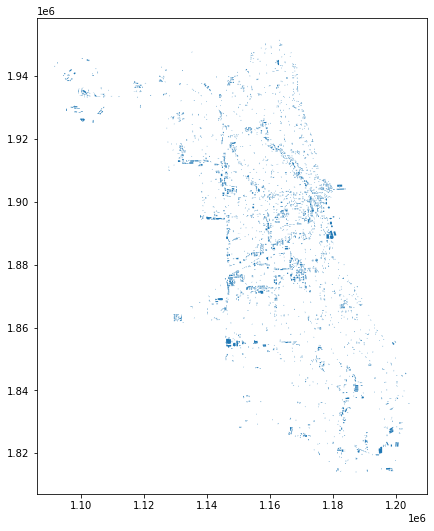

In [33]:
bldgs[bldgs.geometry.area > 30000].plot(figsize=(7,10)) # Another way to specify the figure size

In [7]:
# Set the column names we're interested in
cols = ['bldg_id','bldg_statu','f_add1','pre_dir1','st_name1','st_type1',
        'bldg_name1','bldg_name2','stories','bldg_creat','x_coord','y_coord',
        'no_of_unit','no_stories','year_built', 'geometry']

# Work out the ones we don't need using *not in*
to_drop = [x.upper() for x in bldgs.columns.values if x.lower() not in cols]
print(to_drop)

['CDB_CITY_I', 'T_ADD1', 'UNIT_NAME', 'NON_STANDA', 'COMMENTS', 'ORIG_BLDG_', 'FOOTPRINT_', 'CREATE_USE', 'BLDG_ACTIV', 'BLDG_END_D', 'DEMOLISHED', 'EDIT_DATE', 'EDIT_USERI', 'EDIT_SOURC', 'QC_DATE', 'QC_USERID', 'QC_SOURCE', 'Z_COORD', 'HARRIS_STR', 'BLDG_SQ_FO', 'BLDG_CONDI', 'CONDITION_', 'VACANCY_ST', 'LABEL_HOUS', 'SUF_DIR1', 'SHAPE_AREA', 'SHAPE_LEN']


In [8]:
print(f"Dropping columns: {', '.join(to_drop)}")
bldgs = bldgs.drop(to_drop, axis=1)

Dropping columns: CDB_CITY_I, T_ADD1, UNIT_NAME, NON_STANDA, COMMENTS, ORIG_BLDG_, FOOTPRINT_, CREATE_USE, BLDG_ACTIV, BLDG_END_D, DEMOLISHED, EDIT_DATE, EDIT_USERI, EDIT_SOURC, QC_DATE, QC_USERID, QC_SOURCE, Z_COORD, HARRIS_STR, BLDG_SQ_FO, BLDG_CONDI, CONDITION_, VACANCY_ST, LABEL_HOUS, SUF_DIR1, SHAPE_AREA, SHAPE_LEN


In [9]:
# Rename the columns to lower case
bldgs.columns = [x.lower() for x in bldgs.columns.values]
bldgs.columns.values

array(['bldg_id', 'bldg_statu', 'f_add1', 'pre_dir1', 'st_name1',
       'st_type1', 'bldg_name1', 'bldg_name2', 'stories', 'bldg_creat',
       'x_coord', 'y_coord', 'no_of_unit', 'no_stories', 'year_built',
       'geometry'], dtype=object)

In [10]:
# Initialise to NaN so these will be ones we *don't* set
bldgs['street_nm'] = np.nan
bldgs['address']   = np.nan

In [11]:
bldgs['street_nm'] = bldgs.loc[
                        ~((bldgs.pre_dir1.isna()) | (bldgs.st_name1.isna()) | (bldgs.st_type1.isna())) 
                     ][['pre_dir1','st_name1','st_type1']].apply(lambda row: ' '.join(row.values), axis=1)
bldgs['address']   = bldgs.loc[
                        ~((bldgs.street_nm.isna()) | (bldgs.f_add1.isna()))
                     ][['f_add1','street_nm']].apply(lambda row: ' '.join(row.values.astype('str')), axis=1)

bldgs[['f_add1','pre_dir1','st_name1','st_type1','street_nm','address']].sample(15)

,f_add1,pre_dir1,st_name1,st_type1,street_nm,address
451829,0,None,None,None,NaN,NaN
331215,10720,S,SANGAMON,ST,S SANGAMON ST,10720 S SANGAMON ST
173082,6860,N,TONTY,AVE,N TONTY AVE,6860 N TONTY AVE
94997,0,None,None,None,NaN,NaN
30450,0,None,None,None,NaN,NaN
224645,3938,W,86TH,ST,W 86TH ST,3938 W 86TH ST
354406,0,None,None,None,NaN,NaN
501502,0,None,None,None,NaN,NaN
762174,7023,W,CORNELIA,AVE,W CORNELIA AVE,7023 W CORNELIA AVE
774297,0,None,None,None,NaN,NaN


In [ ]:
# Writing data of this size is *sloooooooooow* compared to QGIS

# 38 minutes to write the shapefile on my machine
#bldgs.to_file(os.path.join('data','geo','buildings.shp'), driver='ESRI Shapefile')

# Not even sure how long this takes!
#bldgs.to_file(os.path.join('data','geo','buildings.gpkg'), driver='GPKG')

In [23]:
gdf = gdf.to_crs(bldgs.crs) # Reproject

<AxesSubplot:>

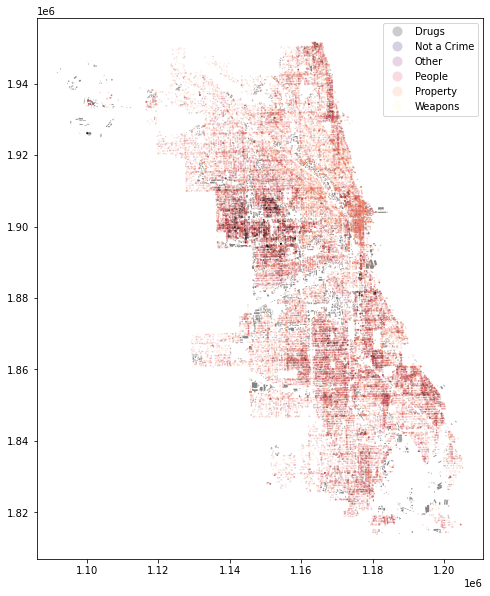

In [31]:
f,ax = plt.subplots(figsize=(8,12))
bldgs[bldgs.geometry.area > 30000].plot(ax=ax, edgecolor='none', facecolor=(0.4, 0.4, 0.4, 0.8))
gdf.plot(ax=ax, column='Class', categorical=True, cmap='magma', markersize=0.25, alpha=0.2, legend=True)

In [26]:
scale  = int(float('1e6')) # This is the scale 
xmin = 1.17*scale
xmax = 1.174*scale
ymin = 1.868*scale
ymax = 1.872*scale
crime_slice = gdf.cx[xmin:xmax, ymin:ymax]
bldg_slice  = bldgs.cx[xmin:xmax, ymin:ymax]
tract_slice = tracts.cx[xmin:xmax, ymin:ymax]

<AxesSubplot:>

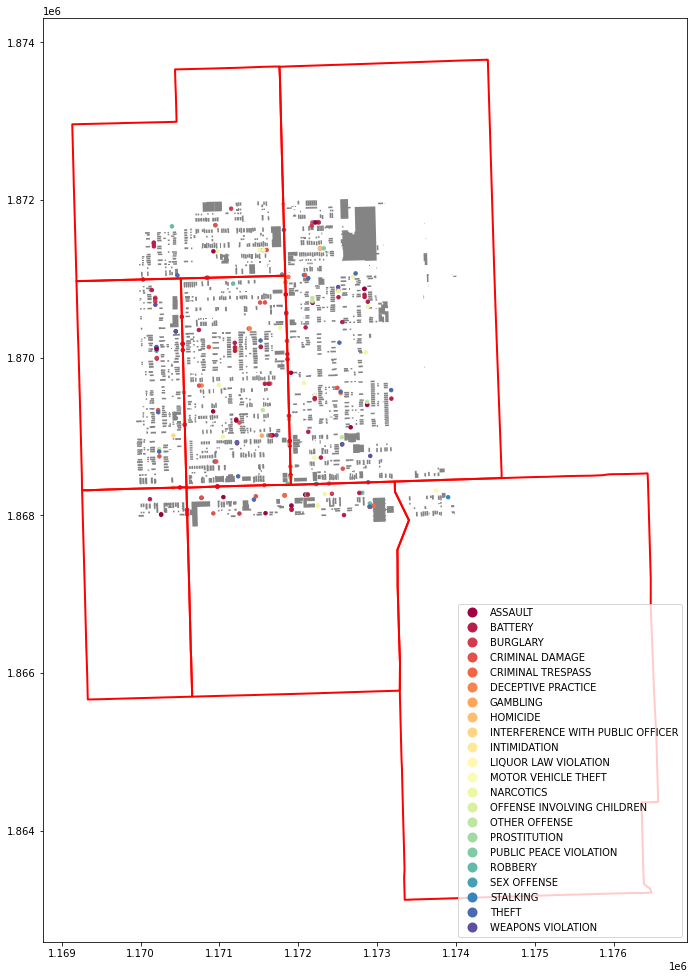

In [27]:
f,ax = plt.subplots(figsize=(15,17))
bldg_slice.plot(ax=ax, edgecolor='none', facecolor=(0.4, 0.4, 0.4, 0.8))
crime_slice.plot(ax=ax, column='Primary Type', cmap='Spectral', markersize=12, legend=True, legend_kwds={'loc':'lower right'})
tract_slice.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=2)

(1868000.0, 1872000.0)

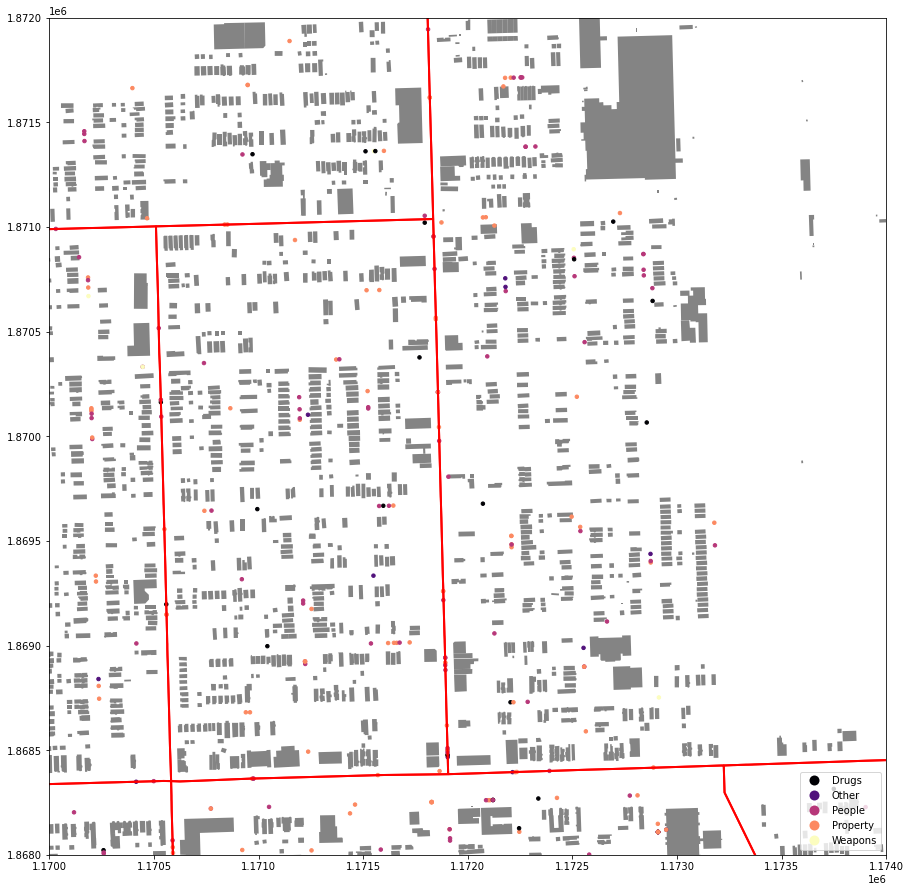

In [30]:
#from mpl_toolkits.axes_grid1 import make_axes_locatable
f,ax = plt.subplots(figsize=(15,17))
bldg_slice.plot(ax=ax, edgecolor='none', facecolor=(0.4, 0.4, 0.4, 0.8))
crime_slice.plot(ax=ax, column='Class', cmap='magma', markersize=12, legend=True, legend_kwds={'loc':'lower right'})
tract_slice.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=2)
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])